<a href="https://colab.research.google.com/github/ChintPatel/CMPE258-Catchup-Quiz-Multimodal/blob/main/Catchup_Quiz_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import random
import os


In [60]:
# Load a few sample images and create dummy captions
IMAGE_COUNT = 6

# Use a few sample images from tf.keras.datasets
(x_train, _), _ = tf.keras.datasets.cifar10.load_data()
sample_images = x_train[:IMAGE_COUNT]

# Generate dummy captions (in real case, you'd load from MS-COCO)
sample_captions = [
    "Deadly Toad.",
    "want to be transformer",
    "Truck Dumping",
    "A Buck",
    "Greatest car know to mankind",
    "zoom zoom car"
]


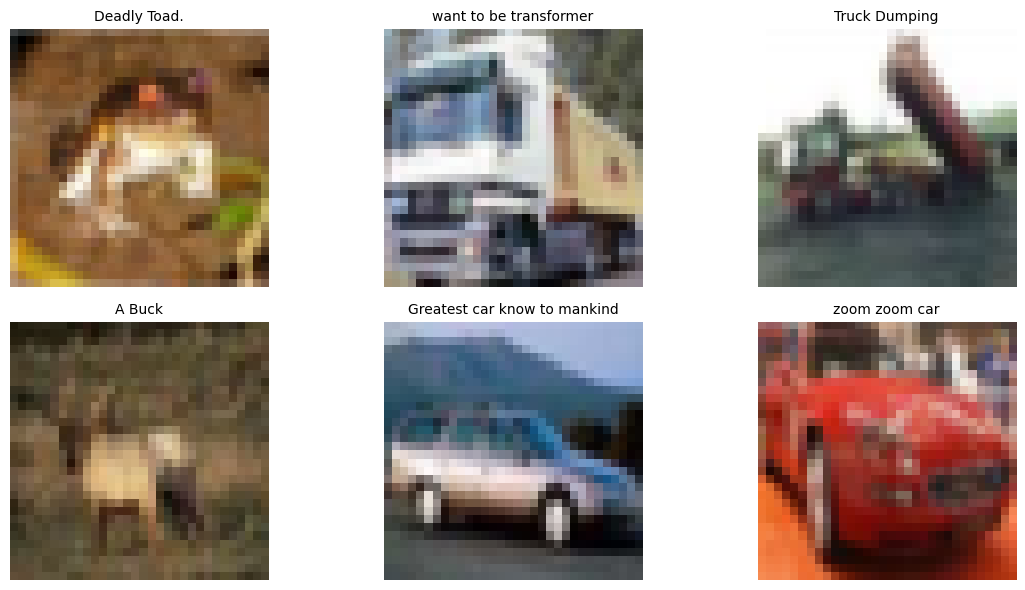

In [61]:
plt.figure(figsize=(12, 6))
for i in range(IMAGE_COUNT):
    plt.subplot(2, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.title(sample_captions[i], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


## 🖼️ Image Captioning

In this section, we build a lightweight image captioning system using:
- **MobileNetV2** as a pre-trained CNN to extract visual features
- A simple **GRU decoder** that takes these features and generates captions
This is a simplified version, designed to run quickly on CPU/Colab.


In [62]:
# Load pre-trained MobileNetV2 (no top layer) to extract image features
mobilenet_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(mobilenet_url, input_shape=(224, 224, 3))

# Freeze weights to avoid training
feature_extractor.trainable = False


In [63]:
def preprocess_image(img):
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img

# Preprocess all sample images
preprocessed_images = tf.stack([preprocess_image(img) for img in sample_images])


In [64]:
image_features = feature_extractor(preprocessed_images)  # Shape: (batch_size, feature_dim)
print("Image feature shape:", image_features.shape)


Image feature shape: (6, 1280)


In [65]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(sample_captions)
caption_seqs = tokenizer.texts_to_sequences(sample_captions)

# Dynamically find max caption length
MAX_SEQ_LEN = max(len(seq) for seq in caption_seqs)

caption_padded = tf.keras.preprocessing.sequence.pad_sequences(
    caption_seqs, padding='post', maxlen=MAX_SEQ_LEN
)

# Create decoder input and target
decoder_input = caption_padded[:, :-1]  # shape (None, MAX_SEQ_LEN - 1)
decoder_target = caption_padded[:, 1:]  # shape (None, MAX_SEQ_LEN - 1)
decoder_target = np.expand_dims(decoder_target, -1)

vocab_size = len(tokenizer.word_index) + 1
SEQ_LEN = decoder_input.shape[1]  # = MAX_SEQ_LEN - 1


In [66]:
EMBEDDING_DIM = 128
UNITS = 256

image_input = tf.keras.Input(shape=(1280,))
caption_input = tf.keras.Input(shape=(SEQ_LEN,))

# Match decoder_input length with RepeatVector
image_emb = tf.keras.layers.RepeatVector(SEQ_LEN)(image_input)

caption_emb = tf.keras.layers.Embedding(vocab_size, EMBEDDING_DIM)(caption_input)

merged = tf.keras.layers.Concatenate()([image_emb, caption_emb])
gru_out = tf.keras.layers.GRU(UNITS, return_sequences=True)(merged)
output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))(gru_out)

caption_model = tf.keras.Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
caption_model.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_6     │ (None, 4, 1280)   │          0 │ input_layer_17[0… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_10        │ (None, 4, 128)    │      2,176 │ input_layer_18[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 4, 1408)   │          0 │ repeat_vector_6[… │
│ (Concatenate)       │                   │            │ embedding_10[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, 4, 256)    │  1,279,488 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 4, 17)     │      4,369 │ gru_5[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,286,033 (4.91 MB)

 Trainable params: 1,286,033 (4.91 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Create shifted output for teacher forcing
decoder_input = caption_padded[:, :-1]
decoder_target = caption_padded[:, 1:]
decoder_target = np.expand_dims(decoder_target, -1)  # Needed for sparse loss


In [68]:
caption_model.fit([image_features, decoder_input], decoder_target, epochs=10)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 2.9440
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 2.3155
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 1.5324
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 1.0286
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 1.0359
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 1.0633
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - loss: 0.9469
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.7826
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - loss: 0.6708
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 0.6299


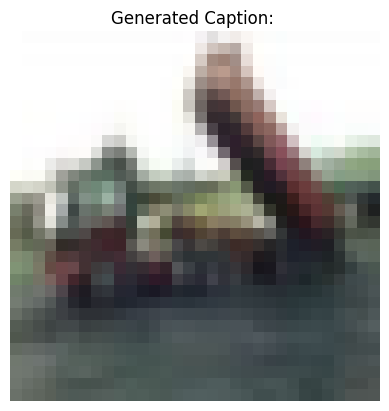

In [69]:
# Simple greedy decoder (just for demo)
index_word = {v: k for k, v in tokenizer.word_index.items()}
index_word[0] = "<PAD>"

def generate_caption(image_feat):
    caption_seq = [tokenizer.word_index['<OOV>']]

    for _ in range(SEQ_LEN):  # generate at most SEQ_LEN words
        # Pad/truncate input to match training time shape
        padded_input = tf.keras.preprocessing.sequence.pad_sequences([caption_seq], maxlen=SEQ_LEN, padding='post')
        pred = caption_model.predict([tf.expand_dims(image_feat, 0), padded_input], verbose=0)
        next_id = tf.argmax(pred[0, len(caption_seq)-1]).numpy()
        if next_id == 0:
            break
        caption_seq.append(next_id)

    return ' '.join([index_word.get(i, '') for i in caption_seq[1:]])


# Test on a sample image
sample_idx = 2
plt.imshow(sample_images[sample_idx])
plt.axis('off')
plt.title("Generated Caption: " + generate_caption(image_features[sample_idx]))
plt.show()


## 🧠 Multimodal Classification

This task combines both **image and text** inputs to classify samples into binary or multiclass categories. We'll:

- Use **MobileNetV2** to extract image features
- Use an **Embedding layer** to represent text inputs
- Combine both modalities using concatenation
- Train a simple **Dense classifier**

The goal is to demonstrate a fast and simple multimodal pipeline using TensorFlow.


In [78]:
# Sample multimodal dataset (images + text + labels)
multi_texts = [
    "Deadly Toad.",
    "want to be transformer",
    "Truck Dumping",
    "A Buck",
    "Greatest car know to mankind",
    "zoom zoom car"
]

# Labels (binary: 1=relevant, 0=irrelevant - dummy logic)
multi_labels = [1, 0, 1, 0, 1, 0]

# Use the same sample_images from earlier
multi_images = sample_images


In [79]:
# Tokenize text
text_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
text_tokenizer.fit_on_texts(multi_texts)
text_seqs = text_tokenizer.texts_to_sequences(multi_texts)

# Pad sequences
text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_seqs, padding='post', maxlen=6)

# Vocabulary size
text_vocab_size = len(text_tokenizer.word_index) + 1
print("Text vocab size:", text_vocab_size)


Text vocab size: 17


In [80]:
# Preprocess and extract MobileNetV2 image features
multi_images_pre = tf.stack([preprocess_image(img) for img in multi_images])
multi_img_features = feature_extractor(multi_images_pre)  # Shape: (batch, 1280)


In [81]:
TEXT_SEQ_LEN = text_padded.shape[1]
TEXT_EMB_DIM = 64

# Inputs
img_input = tf.keras.Input(shape=(1280,))
txt_input = tf.keras.Input(shape=(TEXT_SEQ_LEN,))

# Embed text
txt_emb = tf.keras.layers.Embedding(text_vocab_size, TEXT_EMB_DIM)(txt_input)
txt_flat = tf.keras.layers.GlobalAveragePooling1D()(txt_emb)  # (batch, embedding_dim)

# Combine both modalities
combined = tf.keras.layers.Concatenate()([img_input, txt_flat])
dense1 = tf.keras.layers.Dense(64, activation='relu')(combined)
output = tf.keras.layers.Dense(1, activation='sigmoid')(dense1)

multi_model = tf.keras.Model(inputs=[img_input, txt_input], outputs=output)
multi_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
multi_model.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_13        │ (None, 6, 64)     │      1,088 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_22      │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ embedding_13[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 1344)      │          0 │ input_layer_22[0… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 64)        │     86,080 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         65 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,233 (340.75 KB)

 Trainable params: 87,233 (340.75 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
multi_labels_array = np.array(multi_labels)

multi_model.fit(
    [multi_img_features, text_padded],
    multi_labels_array,
    epochs=20,
    verbose=2
)


Epoch 1/20
1/1 - 2s - 2s/step - accuracy: 0.5000 - loss: 0.8259
Epoch 2/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.4170
Epoch 3/20
1/1 - 0s - 71ms/step - accuracy: 1.0000 - loss: 0.2177
Epoch 4/20
1/1 - 0s - 47ms/step - accuracy: 1.0000 - loss: 0.1124
Epoch 5/20
1/1 - 0s - 58ms/step - accuracy: 1.0000 - loss: 0.0712
Epoch 6/20
1/1 - 0s - 60ms/step - accuracy: 1.0000 - loss: 0.0470
Epoch 7/20
1/1 - 0s - 62ms/step - accuracy: 1.0000 - loss: 0.0305
Epoch 8/20
1/1 - 0s - 55ms/step - accuracy: 1.0000 - loss: 0.0197
Epoch 9/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0130
Epoch 10/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0089
Epoch 11/20
1/1 - 0s - 46ms/step - accuracy: 1.0000 - loss: 0.0064
Epoch 12/20
1/1 - 0s - 59ms/step - accuracy: 1.0000 - loss: 0.0048
Epoch 13/20
1/1 - 0s - 47ms/step - accuracy: 1.0000 - loss: 0.0037
Epoch 14/20
1/1 - 0s - 45ms/step - accuracy: 1.0000 - loss: 0.0029
Epoch 15/20
1/1 - 0s - 58ms/step - accuracy: 1.0000 - loss: 0.0024
Epoch 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


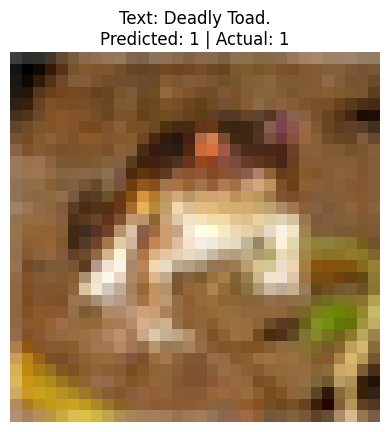

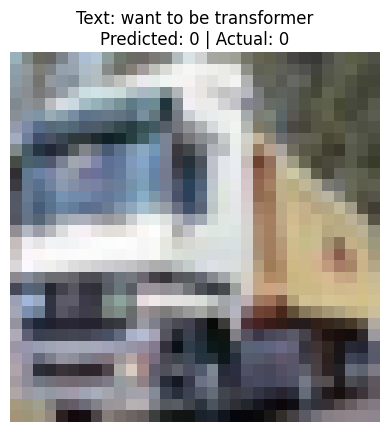

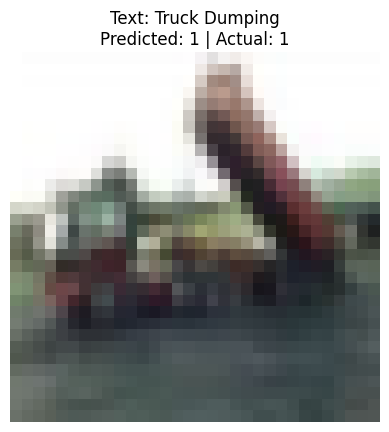

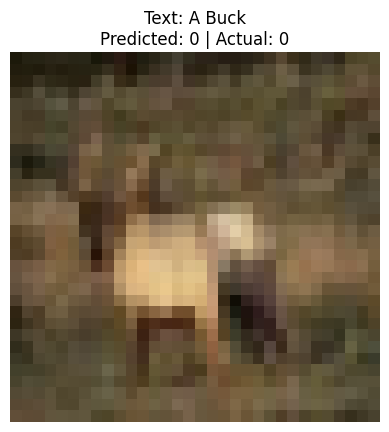

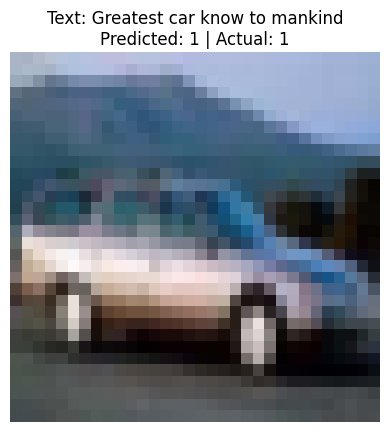

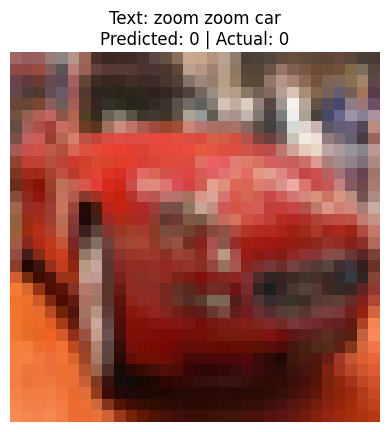

In [83]:
preds = multi_model.predict([multi_img_features, text_padded])
pred_labels = (preds > 0.5).astype(int).flatten()

# Show predictions
for i in range(len(multi_images)):
    plt.imshow(multi_images[i])
    plt.axis('off')
    plt.title(f"Text: {multi_texts[i]}\nPredicted: {pred_labels[i]} | Actual: {multi_labels[i]}")
    plt.show()


## 🔍 Multimodal Retrieval

In this section, we implement a basic **multimodal retrieval** system that matches images with text queries.
The idea is to embed both **images** and **text descriptions** into a shared feature space and then compute **cosine similarity**.

We use:
- MobileNetV2 for image embeddings
- Global average-pooled text embeddings for queries


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

🔹 Query: "Deadly Toad."
📸 Top Retrieved Image:


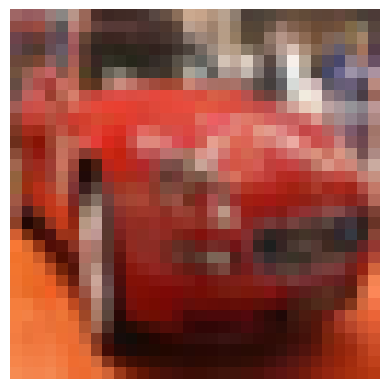


🔹 Query: "want to be transformer"
📸 Top Retrieved Image:


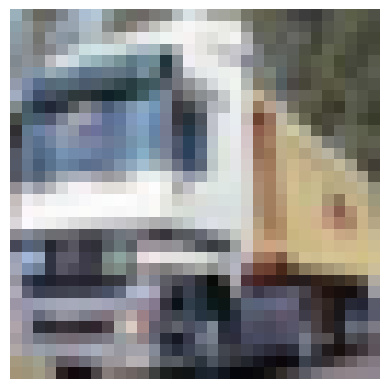


🔹 Query: "Truck Dumping"
📸 Top Retrieved Image:


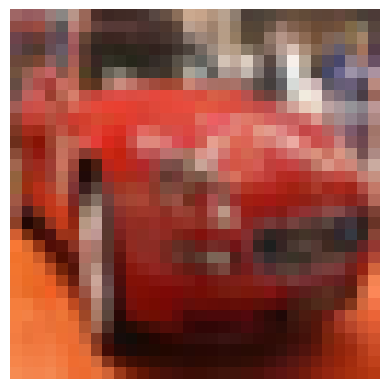


🔹 Query: "A Buck"
📸 Top Retrieved Image:


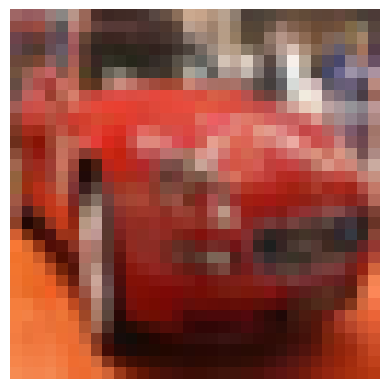


🔹 Query: "Greatest car know to mankind"
📸 Top Retrieved Image:


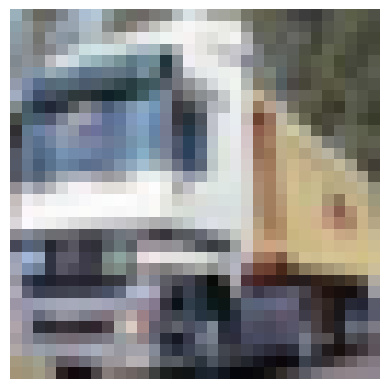


🔹 Query: "zoom zoom car"
📸 Top Retrieved Image:


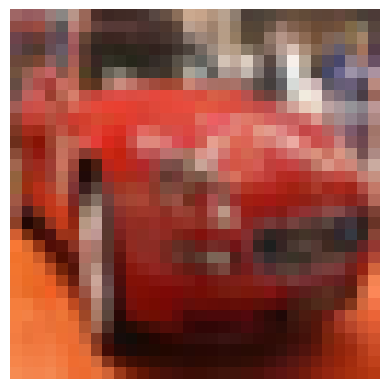

In [84]:
import tensorflow.keras.backend as K
from sklearn.metrics.pairwise import cosine_similarity

# Reuse previously preprocessed images
retrieval_images = sample_images
retrieval_texts = sample_captions  # same descriptions from Part 1

# Extract image embeddings again (already done earlier, but repeat here for clarity)
retrieval_preprocessed = tf.stack([preprocess_image(img) for img in retrieval_images])
img_embeddings = feature_extractor(retrieval_preprocessed).numpy()

# Tokenize text and embed
retrieval_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token="<OOV>")
retrieval_tokenizer.fit_on_texts(retrieval_texts)
text_seq = retrieval_tokenizer.texts_to_sequences(retrieval_texts)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_seq, padding='post', maxlen=6)

# Simple embedding model for text
VOCAB_SIZE = len(retrieval_tokenizer.word_index) + 1
EMB_DIM = 64

text_input = tf.keras.Input(shape=(text_pad.shape[1],))
text_emb = tf.keras.layers.Embedding(VOCAB_SIZE, EMB_DIM)(text_input)
text_vec = tf.keras.layers.GlobalAveragePooling1D()(text_emb)
text_model = tf.keras.Model(inputs=text_input, outputs=text_vec)

# Generate text embeddings
text_embeddings = text_model.predict(text_pad)

# Project both into a shared space (e.g., 256D)
PROJ_DIM = 256

# Dense layers to match embedding dimensions
img_proj_layer = tf.keras.layers.Dense(PROJ_DIM)
txt_proj_layer = tf.keras.layers.Dense(PROJ_DIM)

img_proj = img_proj_layer(img_embeddings)
text_proj = txt_proj_layer(text_embeddings)

# Normalize for cosine similarity
img_norm = img_proj / np.linalg.norm(img_proj, axis=1, keepdims=True)
text_norm = text_proj / np.linalg.norm(text_proj, axis=1, keepdims=True)


# Compute cosine similarity matrix (text queries x images)
similarity_matrix = cosine_similarity(text_norm, img_norm)

# Show top retrieval result for each text
for i in range(len(retrieval_texts)):
    best_match = np.argmax(similarity_matrix[i])
    print(f"\n🔹 Query: \"{retrieval_texts[i]}\"")
    print(f"📸 Top Retrieved Image:")
    plt.imshow(retrieval_images[best_match])
    plt.axis('off')
    plt.show()


## ✅ Conclusion

In this notebook, we demonstrated three practical use cases of lightweight **multimodal deep learning** using TensorFlow:

1. **Image Captioning** — Generated text captions from image features using MobileNetV2 + GRU.
2. **Multimodal Classification** — Combined image and text features to classify inputs into binary categories.
3. **Multimodal Retrieval** — Matched image-text pairs based on cosine similarity in a shared embedding space.

These examples use fast, low-resource models and are ideal for academic demos, project prototypes, or quick experiments on Colab. They show how vision and language models can be integrated in meaningful ways, even with minimal data and compute.

---
